In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import pandas as pd
import numpy as np
from pathlib import Path
import fitz
from fitz import Rect
from PIL import Image
import sys, re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances

from pdf_scraper.doc_utils   import open_exam, get_doc_line_df, identify_section_headers, identify_text_headers, get_path_from_doc
from pdf_scraper.doc_utils   import identify_footers, identify_instructions, identify_subtitles, identify_subsubtitles
from pdf_scraper.line_utils  import clean_line_df, get_df_bbox
from pdf_scraper.doc_utils   import get_images, filter_images, get_raw_lines, assign_in_image_captions, identify_vertical_captions
from pdf_scraper.clustering.cluster_utils import find_y0_dL
from pdf_scraper.image_utils import show_image, show_all_imgs

pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_colwidth", 200)

In [46]:
# get cluster bboxes
def get_cluster_boxes(df, labels):
    rectangies = []
    clust_labes = np.unique(labels)[1:] if -1 in labels else np.unique(labels)
    for i in clust_labes:
        temp_df = df[df.cluster==i]
        rectangies.append( Rect(get_df_bbox(temp_df)) )
    return rectangies

def get_category_boxes(df, cat):
    rectangies = []
    clust_labes = np.unique(df[cat])[1:] if -1 in df[cat] else np.unique(df[cat])
    for i in clust_labes:
        temp_df = df[df[cat]==i]
        rectangies.append( Rect(get_df_bbox(temp_df)) )
    return rectangies

def enrich_doc_df_with_images(df, images):
    poo = {val: [ img["bbox"][i] for img in images ] for i, val in enumerate(["x0","y0","x1","y1"])}
    img_dict = { }
    for i, coord in enumerate(["x0","y0","x1","y1"]):
        img_dict[coord]   = [ img["bbox"][i] for img in images ]
    img_dict["page"]  = [ img["page"]   for img in images]
    img_dict["image"] = [1]*len(images)
    img_df = pd.DataFrame(img_dict)    
    rich_df = pd.concat([df, img_df],ignore_index=True).sort_values(by=["page","y0"],ignore_index=True)
    
    return rich_df

def get_bboxed_page_image(doc,  page_number: int, rects: list[Rect],  color: tuple[float]=(0,0,0.0), labels: list[int] = [], ) -> Image:
    i_p  = int(page_number-1)

    out_doc = fitz.open()
    out_doc.insert_pdf(doc, from_page=i_p, to_page=i_p)
    page = out_doc[0]

    for i, rect in enumerate(rects):
        page.draw_rect(rect, color=color, width=3)
        if len(labels) >0:
            label_text = str(labels[i])
            pos = fitz.Point(rect.x0, rect.y0 - 2)  # adjust -2 for spacing
            page.insert_text(pos, label_text, fontsize=8, color=(1,0,0))

    pix = page.get_pixmap(matrix=fitz.Matrix(1, 1))  # scale=2 for higher resolution
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    out_doc.close()

    return img



In [47]:
def df_bbox_next_row_dist(y0, y1, y0_next, y1_next):
    """End-to-end vertical distance between two line segments.

    This function will return 0 if the two bboxes overlap in the chosen dimension.
    Otherwise it will return the distance between their closest endpoints.
    """
    overlap = np.maximum(y0, y0_next) <= np.minimum(y1, y1_next)
    dist = np.where(overlap, 0.0, np.minimum(np.abs(y1 - y0_next), np.abs(y1_next - y0)))
    return dist

def df_bbox_dist(row1, row2):
    """
    This calculates the bbox end to end distance between to dataframe rows.

    It can be used to generate a distance matrix between all rows of a dataframe of lines.
    
    df_bbox_dist(row1[["y0","y1]], row2[["y0","y1"]]) = vertical   end to end bbox distance
    df_bbox_dist(row1[["x0","x1]], row2[["x0","x1"]]) = horizontal end to end bbox distance
    """
    y0, y1 = row1
    y0_next, y1_next = row2

    overlap = max(y0, y0_next) <= min(y1, y1_next)
    if overlap:
        return 0.0
    return min(abs(y1 - y0_next), abs(y1_next - y0))


def split_cluster(df: pd.DataFrame, i_clust: int,  metric, eps, dir, verbose=False):
    if verbose: print(f"scanning cluster {i_clust}")
    last_id  = df.cluster.max()
    clust_df = df[df.cluster==i_clust].copy()

    X             = pairwise_distances(clust_df[dir],metric=metric)
    scan          = DBSCAN(eps=eps, min_samples=1,metric="precomputed")
    labels        = scan.fit_predict(X)
    
    unique_labels = np.unique(labels)
    n_labels = len( unique_labels )
    if n_labels ==1:
        if verbose: print("No split")
        return  unique_labels
    
    labels[labels!=0] += last_id
    labels[labels==0] += i_clust

    df.loc[clust_df.index, "cluster"] = labels
    unique_labels = np.unique(labels)
    
    if verbose: print(f"Cluster {i_clust} split {dir[0][0]} into {n_labels} clusters: {unique_labels}")

    return unique_labels


def hdbscan(df: pd.DataFrame, max_iter: int, eps_x: float, eps_y: float, metric, verbose=False):
    dirs = ((["y0","y1"], eps_y), (["x0","x1"],eps_x))
    i_dir = 0
    df["cluster"]=0
    N_clusters=1
    n_fail = 0
    imgs=[]
    
    for n_loop in range(max_iter):
        # assign the direction and cluster numbers for this round of scanning
        dir = dirs[i_dir][0] ; eps = dirs[i_dir][1]
    
        print(f"Full Scan {n_loop} in {dir[0][0]} with eps={eps:<6.0f}")
        if n_fail >=4:
            break
        # Loop over all current clusters and break up in dir
        for i_clust in np.unique(df.cluster):
            split_cluster(df, i_clust, metric, eps, dir, verbose=verbose)
                
        labelos = np.unique(df.cluster)
        n_clusters = len(labelos)
        i_dir = 1 if i_dir==0 else 0
    
        if n_clusters == N_clusters:
            n_fail +=1
            continue
        else:
            n_fail = 0
            N_clusters = n_clusters
    
        rectangies = get_category_boxes(df, 'cluster')
        imgs.append(get_bboxed_page_image(doc, page, rectangies,color=(0.0,0,0.0), labels=labelos))
        print(f"Total {n_clusters} clusters: {labelos}")
        return imgs

In [48]:
year=2019
#year=2002
doc    = open_exam(year, "english", "al",1)
df     = get_doc_line_df(doc)

images = get_images(doc)
images = filter_images(images)
assign_in_image_captions(df,images)

doc_width     = doc[0].rect.width
middle        = doc_width/2
standard_font = df.mode_font.mode()[0]
median_font   = df.font_size.median()


df = clean_line_df(df)
identify_footers(df)
identify_instructions(df)
identify_section_headers(df)
identify_text_headers(df, doc_width)
identify_subtitles(df, doc_width)
identify_subsubtitles(df,doc_width)


for image in images:
    if image["page"] <2 or image["page"] >8:
        continue
    identify_vertical_captions(df, image)

page: 6


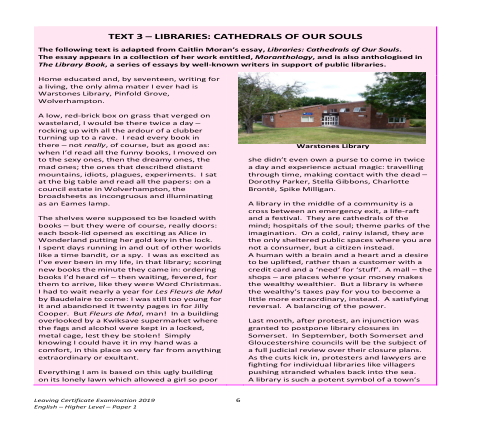

In [49]:
page = np.unique(df[df.caption2==1].page)[0]
page_df = df.loc[df.page==page, ["text", 'x0', 'y0', 'x1', 'y1', "page","w"]].copy()
page_images = [image for image in images if image["page"]==page]
page_df = enrich_doc_df_with_images(page_df,page_images)
page_df["dL"] = page_df.y0.diff()

doc_page = doc[int(page-1)]
pix = doc_page.get_pixmap(matrix=fitz.Matrix(0.8, 0.5))  # scale=2 for higher resolution
img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
print(f"page: {page}")
display(img)

## Separate y0 and x0 scans 

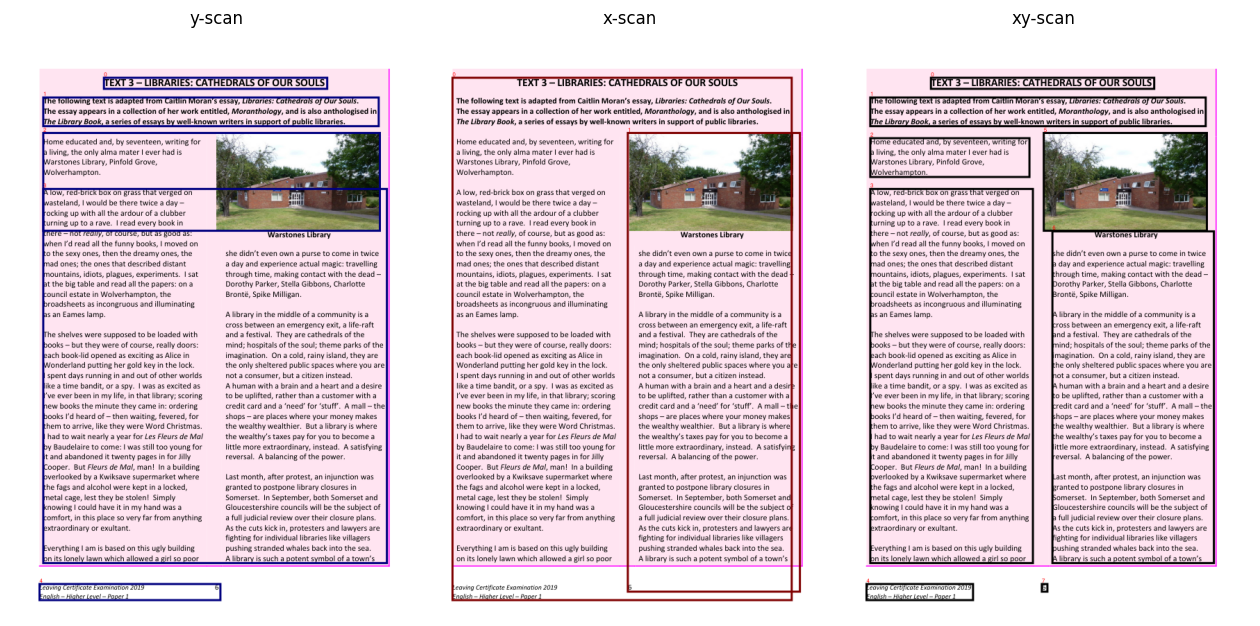

In [ ]:
eps_y0 = dL_y0 = find_y0_dL(page_df)*1.15
scan_y = DBSCAN(eps=dL_y0, min_samples=1)
page_df["y_cluster"]= scan_y.fit_predict(page_df[["y0"]])


median_w = page_df.w.dropna().map(round).median()
eps_x0    = median_w*0.5
scan_x = DBSCAN(eps=eps_x0, min_samples=1)
page_df["x_cluster"]= scan_x.fit_predict(page_df[["x0"]])

rectangies_y = get_category_boxes(page_df, 'y_cluster')
y_img = get_bboxed_page_image(doc, page, rectangies_y, color=(0,0,0.5), labels=np.unique(page_df.y_cluster) )


rectangies_x = get_category_boxes(page_df, 'x_cluster')
x_img = get_bboxed_page_image(doc, page, rectangies_x,color=(0.5,0,0.0),labels = np.unique(scan_x.labels_))

# Join lcluster labels
page_df["xy_cluster"] = page_df.groupby(["x_cluster", "y_cluster"]).ngroup()
rectangies_xy = get_category_boxes(page_df, 'xy_cluster')
xy_img = get_bboxed_page_image(doc, page, rectangies_xy,color=(0.0,0,0.0),labels=np.unique(page_df.xy_cluster))

fig, axes = plt.subplots(1,3,figsize=(16,8))

axes[0].imshow(y_img); axes[0].axis("off"); axes[0].set_title("y0-scan");
axes[1].imshow(x_img); axes[1].axis("off"); axes[1].set_title("x0-scan")
axes[2].imshow(xy_img); axes[2].axis("off"); axes[2].set_title("x0y0-scan")
plt.subplots_adjust(wspace=0.0)


- This is an improved clustering. But we notice that not all pagraphs are separated in y
  - Do another y clustering within each group.
  - The issue is that, when looking only at y, the existence of "A library in the middle" to the right of the paragraph ending in "Eames lamp" gives a false
    impression of contiguity.

# Hierarchical alternating scan till stability

Full Scan 0 in y with eps=17    
Total 48 clusters: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]


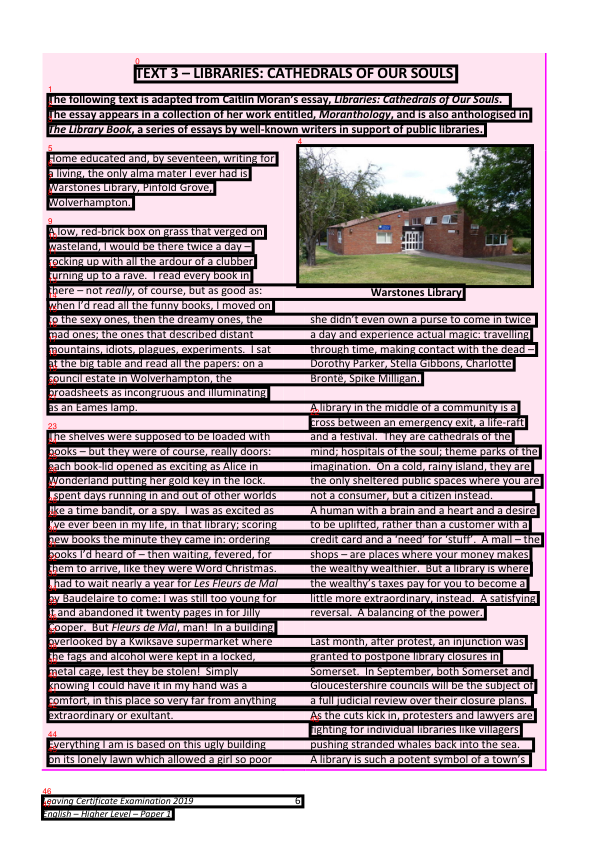

In [54]:
from time import sleep
median_dy0 = find_y0_dL(page_df)
median_w   = page_df.w.median()
eps_y0     = median_dy0*1.15
eps_x0     = median_w*0.5

imgs = hdbscan(page_df, 100, eps_x0, eps_y0, "euclidean",False )
imgs[0]

# Scan using bbox distances